<div class="alert alert-block alert-info">
This script <b>filters the data according to the United Nations Central Product Classification (CPC) v2.1. divisions</b>.
    <hr> 
    Note: <br>
    <i><b>Input file(s)' name(s) and metadata</b></i> (if available) are <b>printed out (below 👇🏼) in 'read data to df' section.</b><br><br>
    
    Ref: <a href="https://digitallibrary.un.org/record/3900378">CPCv2.1_complete(PDF)_English.pdf</a>
</div>

In [1]:
# %env
# %who_ls
# %who
# %who int
# %pinfo <var name>

# Imports

In [2]:
%config IPCompleter.use_jedi = False # disable jedi autocompleter (https://stackoverflow.com/a/65734178/14485040)

import project_path  # makes possible the access to `src` directory using relative path
from src.data import filter_dataframe, internal_funcs
from src.utils import explore_dir, make_readme_info
from src.utils import read_excel_to_pandas as r_excel
from src.utils import set_outputs_dir
from src.utils import write_pandas_to_excel as w_excel

%run init_nb.ipynb

# INPUTS: Identify file(s) and read data to df

In [3]:
# Explore the directory to find the file(s)
inputs_dir, files_list = explore_dir(
    path_to_dir=r"..\data\interim", file_extension="xlsx", print_files_list=True
)

['CPC33to36_other_chemicals.xlsx',
 'data-filtered-cpc-33to36-divisions.xlsx',
 'df_chemproperties.xlsx',
 'extended-data-chosen-methods-metadata-pubchem-properties.xlsx',
 'lcia-results-from-sp910-combined.xlsx',
 'list-chemicals-not-shown-on-fig-prices-vs-impacts.xlsx',
 'list-chemicals-not-shown-on-fig3.xlsx',
 'list-outliers.xlsx',
 'mapped-lcia-results.xlsx',
 'pubchem-properties.xlsx',
 'raw-data-chosen-lcia-methods-and-metadata.xlsx',
 'temp-df_base_full_wCAS.xlsx',
 'temp-df_base_full_wCAS_woOutliersRMDk9a5.xlsx',
 'temp-dict_fullMethods.xlsx',
 'to-check-regrouped-data-other-chemicals-category.xlsx']


In [4]:
# Read data
df_analysis = r_excel(
    inputs_dir, "extended-data-chosen-methods-metadata-pubchem-properties.xlsx"
)
print(
    "df_analysis".ljust(40, "."), f"{df_analysis.shape}\n".rjust(13, "."),
)

# Get list of LCIA methods and list of metadata
METHODS = r_excel(
    inputs_dir,
    "extended-data-chosen-methods-metadata-pubchem-properties.xlsx",
    sheets="METHODS",
    show_readme=False,
)["METHODS"].to_list()

METADATA = r_excel(
    inputs_dir,
    "extended-data-chosen-methods-metadata-pubchem-properties.xlsx",
    sheets="METADATA",
    show_readme=False,
)["METADATA"].to_list()


===> Trying to load 'readme' data... ===
File: extended-data-chosen-methods-metadata-pubchem-properties.xlsx from
C:\Users\ViteksPC\Documents\00-ETH_projects\17-AESA_ecoinvent_chemicals\notebooks\0.21-vt-extend-data-by-adding-pubchem-properties.ipynb
Generated on 2021-07-30 (Friday), 16:17:54 by Tulus, V.
Includes:
<<<
Sheet1: Extended data with chosen LCIA methods, important metadata and PubChem properties
METADATA: list of relevant metadata used in Sheet1.
METHODS: list of LCIA methods used in Sheet1.
[METHODS + METADATA have to be the only column labels in Sheet1]
>>>

df_analysis............................. ...(946, 38)



In [5]:
pd.options.display.max_columns = None

# Operations 
<div class="alert alert-block alert-info">
filter the df using CPC classification <strong>(only divisions 3.3 to 3.6)</strong>
</div>

Updated **df_analysis** dataframe is of (946, 39) shape.

category_regrouped
34: Basic chemicals                                                 719
35: Other chemical products; man-made fibres                         88
33: Coke oven products; refined petroleum products; nuclear fuel     71
Other products (not in CPC: 33-36 divisions)                         54
36: Rubber and plastics products                                     14
dtype: int64
Total:  946

Shares in % for  category_regrouped
33: Coke oven products; refined petroleum products; nuclear fuel     7.51
34: Basic chemicals                                                 76.00
35: Other chemical products; man-made fibres                         9.30
36: Rubber and plastics products                                     1.48
Other products (not in CPC: 33-36 divisions)                         5.71
dtype: float64


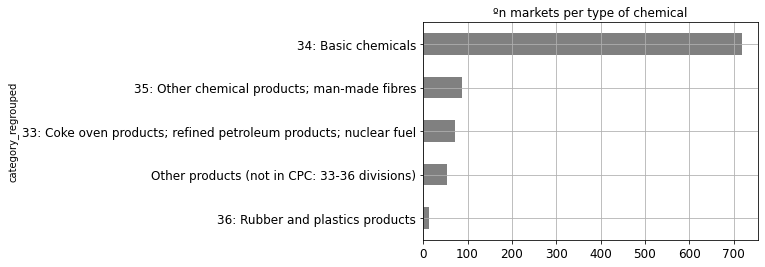

In [6]:
regrouped_cat = []
for item in df_analysis.index:
    if str(df_analysis.referenceProduct_CPCclass[item]).startswith("33"):
        regrouped_cat.append(
            "33: Coke oven products; refined petroleum products; nuclear fuel"
        )
    elif str(df_analysis.referenceProduct_CPCclass[item]).startswith("34"):
        regrouped_cat.append("34: Basic chemicals")
    elif str(df_analysis.referenceProduct_CPCclass[item]).startswith("35"):
        regrouped_cat.append("35: Other chemical products; man-made fibres")
    elif str(df_analysis.referenceProduct_CPCclass[item]).startswith("36"):
        regrouped_cat.append("36: Rubber and plastics products")
    else:
        regrouped_cat.append("Other products (not in CPC: 33-36 divisions)")

try:
    df_analysis.insert(1, "category_regrouped", regrouped_cat, allow_duplicates=False)
except:
    df_analysis.drop("category_regrouped", axis=1, inplace=True)
    df_analysis.insert(1, "category_regrouped", regrouped_cat)


# (!) update the list of non-method column labels
METADATA = list(filter(lambda a: a != "category_regrouped", METADATA))
METADATA.insert(1, "category_regrouped")
print("Updated **df_analysis** dataframe is of {} shape.\n".format(df_analysis.shape))
df_analysis.sample(2)

internal_funcs.plot_categories(
    df_in=df_analysis,
    groupby="category_regrouped",
    color="gray",
    fontsize=12,
    cutoff_value=8,
)

Created **df_cpc33to36** dataframe is of (892, 39) shape.

category_regrouped
34: Basic chemicals                                                 719
35: Other chemical products; man-made fibres                         88
33: Coke oven products; refined petroleum products; nuclear fuel     71
36: Rubber and plastics products                                     14
dtype: int64
Total:  892

Shares in % for  category_regrouped
33: Coke oven products; refined petroleum products; nuclear fuel     7.96
34: Basic chemicals                                                 80.61
35: Other chemical products; man-made fibres                         9.87
36: Rubber and plastics products                                     1.57
dtype: float64


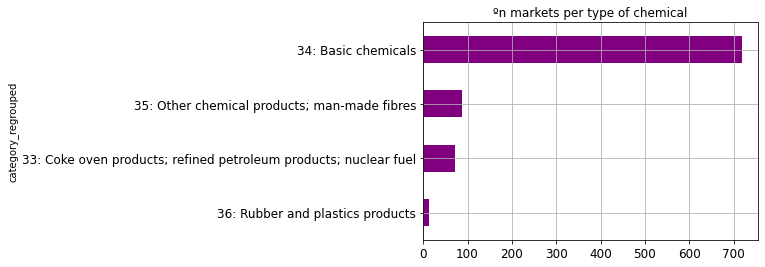

In [7]:
# drop all activities not from CPC 33-36
df_cpc33to36 = filter_dataframe(
    df_analysis,
    col_name="category_regrouped",
    filter_out=[
        "Other products (not in CPC: 33-36 divisions)",
#         "36: Rubber and plastics products",
    ],
)
print(
    "Created **df_cpc33to36** dataframe is of {} shape.\n".format(
        df_cpc33to36.shape
    )
)
# df_cpc33to36.sample(3)

internal_funcs.plot_categories(
    df_in=df_cpc33to36,
    groupby="category_regrouped",
    color="purple",
    fontsize=12,
    cutoff_value=8,
)

In [8]:
print("".ljust(40, "="))
print(
    "Before creating new GLO markets, there are {} unique GLO markets with FU=1kg "
    "belonging to CPC 33-36 in the database."
    "\nAnd {} non-GLO markets with FU=1kg, of which {} are unique.".format(
        df_cpc33to36[
            (df_cpc33to36.geo == "GLO")
            & (df_cpc33to36.referenceProductUnit == "kg")
        ]
        .referenceProduct.unique()
        .shape[0],
        df_cpc33to36[
            (df_cpc33to36.geo != "GLO")
            & (df_cpc33to36.referenceProductUnit == "kg")
        ].shape[0],
        df_cpc33to36[
            (df_cpc33to36.geo != "GLO")
            & (df_cpc33to36.referenceProductUnit == "kg")
        ]
        .referenceProduct.unique()
        .shape[0],
    )
)

Before creating new GLO markets, there are 469 unique GLO markets with FU=1kg belonging to CPC 33-36 in the database.
And 414 non-GLO markets with FU=1kg, of which 201 are unique.


In [9]:
# Make df of METADATA and METHODS for later export
df_metadata = pd.DataFrame(METADATA, columns=["METADATA"])
df_methods = pd.DataFrame(METHODS, columns=["METHODS"])

# OUTPUTS: Export data to excel

In [10]:
%%time

# Set output directory
outputs_dir = set_outputs_dir(use_default=True)  # default `..\data\interim`

## Export dataframe to excel
excelName = "data-filtered-cpc-33to36-divisions.xlsx"

df_readme = make_readme_info(
    excelName,
    "Sheet1: Filtered dataframe includes any chemicals "
    "that belong to CPC divisions 33, 34 , 35 or 36."
    "\nMETADATA: list of relevant metadata used in Sheet1."
    "\nMETHODS: list of LCIA methods used in Sheet1."
    "\n[METHODS + METADATA have to be the only column labels in Sheet1]",
)

w_excel(
    path_to_file=outputs_dir,
    filename=excelName,
    dict_data_to_write={
        "Sheet1": df_cpc33to36,
        "METADATA": df_metadata,
        "METHODS": df_methods,
    },
    readme_info=("readme", df_readme),
    #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
    #     startrow=0
)

File: data-filtered-cpc-33to36-divisions.xlsx successfully created in 
C:\Users\ViteksPC\Documents\00-ETH_projects\17-AESA_ecoinvent_chemicals\data\interim
Wall time: 1 s
